In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import itertools

In [2]:
predictions = []
oofs = []

weights = {'rf':2,'lr':1,'lgb':3}
models = list(weights.keys())
weights_list = list(weights.values())

for model in models:
    for index in range(5):
        with open(f'predictions1/{model}_{index}.pkl','rb') as f:
            predictions.append(pickle.load(f))
    with open(f'oofs1/{model}.pkl','rb') as f:
        oofs.append(pickle.load(f))

In [3]:
# # find best weights

# weights_rf = [1,2,3,4,5]
# weights_lr = [1,2,3,4,5]
# weights_lgb = [1,2,3,4,5]

# train_df = pd.read_csv('data/cleaned_train.csv',index_col=0)
# y2 = train_df['class2'].map({'nonevent':0,'event':1})

# current_best = 0
              
# for weight_rf in weights_rf:
#     for weight_lr in weights_lr:
#         for weight_lgb in weights_lgb:
#             weights = {'rf':weight_rf,'lr':weight_lr,'lgb':weight_lgb}
#             models = list(weights.keys())
#             weights_list = list(weights.values())
#             oof2 = []

#             for index in range(len(y2)):
#                 counter = [0,0]
#                 preds = [oofs[i][index] for i in range(len(oofs))]
#                 for i,pred in enumerate(preds):
#                     counter[0] += weights_list[i] * pred[0]
#                     counter[1] += weights_list[i] * pred[1]

#                 oof2.append(np.argmax(counter))

#             acc2 = accuracy_score(y2,oof2)
#             if acc2 > current_best:
#                 current_best = acc2
#                 best_rf = weight_rf
#                 best_lr = weight_lr
#                 best_lgb = weight_lgb

# best_rf,best_lr,best_lgb,current_best

In [4]:
# # perplexity optimizer
# train_df = pd.read_csv('data/cleaned_train.csv',index_col="date")
# y2 = train_df['class2'].map({'nonevent':0,'event':1})

# def get_perplexity(coefficient=1):
#     confidences = []

#     for index in range(len(y2)):
#         counter = [0,0]
#         preds = [oofs[i][index] for i in range(len(oofs))]
#         for i,pred in enumerate(preds):
#             counter[0] += weights_list[i] * pred[0]
#             counter[1] += weights_list[i] * pred[1]
#         confidences.append(coefficient * counter[1] / (counter[0] + coefficient * counter[1]))

#     return np.exp(log_loss(y2,confidences)/len(y2))

# current_best = float('inf')

# for i in range(15,35):
#     if get_perplexity(coefficient=i/20) < current_best:
#         best_coefficient = i / 20
#         current_best = get_perplexity(coefficient=i/20)

# best_coefficient

In [5]:
coefficient = 1

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
# Cross validation score, used as estimate of final accuracy
train_df = pd.read_csv('data/cleaned_train.csv',index_col=0)
y2 = train_df['class2'].map({'nonevent':0,'event':1})
oof2 = []
confidences = []

for index in range(len(y2)):
    counter = [0,0]
    preds = [oofs[i][index] for i in range(len(oofs))]
    for i,pred in enumerate(preds):
        counter[0] += weights_list[i] * pred[0]
        counter[1] += weights_list[i] * pred[1]

    oof2.append(np.argmax(counter))
    confidences.append(coefficient * counter[1] / (counter[0] + coefficient * counter[1]))
    
acc2 = accuracy_score(y2,oof2)
print("2 class")
print("ACC:",str(acc2))
# perplexity
print("PERP:",np.exp(log_loss(y2,confidences)))
print(confusion_matrix(y2,oof2))
with open('results/acc2.pkl','wb') as f:
    pickle.dump(acc2,f)

2 class
ACC: 0.9017467248908297
PERP: 1.3155622513636809
[[216  13]
 [ 32 197]]


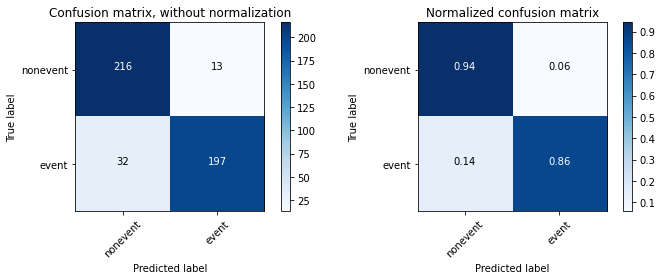

In [8]:
cnf_matrix2 = confusion_matrix(y2, oof2)
# Compute confusion matrix
class_names2 = ['nonevent', 'event']

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 4))

np.set_printoptions(precision=4)
# Plot non-normalized confusion matrix
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix2, classes=class_names2,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix2, classes=class_names2, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("Fig/cm2.png", dpi = 1080)
plt.show()

In [9]:
final_confidences = []
stage1_predictions = []
length = len(predictions[0])

for index in range(length):
    counter = [0,0]
    preds = [predictions[i][index] for i in range(len(predictions))]
    for i,pred in enumerate(preds):
        weight_index = int(i / 5) 
        counter[0] += weights_list[weight_index] * pred[0]
        counter[1] += weights_list[weight_index] * pred[1]
    stage1_predictions.append(np.argmax(counter))
    confidence = coefficient * counter[1] / (counter[0] + coefficient * counter[1])
    final_confidences.append(confidence)
        
len(stage1_predictions)

965

In [10]:
stage2_indexes = []

for index, prediction in enumerate(stage1_predictions):
    if prediction == 1:
        stage2_indexes.append(index)

In [11]:
with open('results/stage1_predictions.pkl','wb') as f:
    pickle.dump(stage1_predictions,f)
    
with open('results/final_confidences.pkl','wb') as f:
    pickle.dump(final_confidences,f)
    
with open('data/stage2_indexes.pkl','wb') as f:
    pickle.dump(stage2_indexes,f)